In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from Loss.triplet import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True; torch.cuda.is_available(); 
torch.cuda.get_device_name(0)

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


'GeForce GTX 770'

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [5]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=True)

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 68),
    nn.ReLU(),
    nn.Linear(68, 3))

model

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=68, bias=True)
  (4): ReLU()
  (5): Linear(in_features=68, out_features=3, bias=True)
)

In [8]:
criterion = TripletLoss()
optim_fn = optim.Adam

In [9]:
sess = Session(model, criterion, optim_fn, 1e-3)

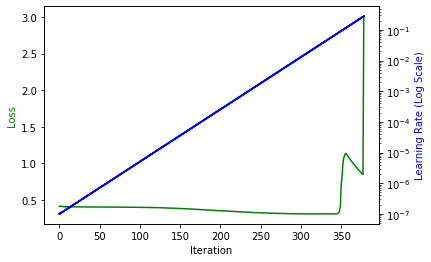

In [10]:
lr_find(sess, trainloader, start_lr=1e-7)

In [11]:
sess.set_lr(1e-4)

In [15]:
schedule = TrainingSchedule(trainloader, [LossLogger(), CosAnneal(len(trainloader), T_mult=2)])

In [ ]:
sess.train(schedule, 8)

Training Loss: 0.3034597337245941


Training Loss: 0.30007681250572205


Training Loss: 0.30004823207855225


Training Loss: 0.30005770921707153


Training Loss: 0.3000345230102539


In [ ]:
model

In [ ]:
with EvalModel(model):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for input, label in valloader:
        preds = model.forward(Variable(util.to_gpu(input))).data.cpu().numpy()
        ax.scatter(preds[:,0], preds[:,1], preds[:,2], c=label)